In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mne
import pickle
import seaborn as sns
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from statannotations.Annotator import Annotator
import matplotlib.animation as animation
from matplotlib import patches

plt.rcParams.update({'font.size': 14})

In [2]:
# get the rgb code of orange in matplotlib
orange = matplotlib.colors.to_rgb('orange')
# get the rgb code of blue in matplotlib
blue = matplotlib.colors.to_rgb('blue')

# Load meg channel config
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...
    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.


<ipython-input-2-eadfb0127d98>:15: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


Reading 0 ... 232999  =      0.000 ...   232.999 secs...


# Pairwise comparison

In [ ]:
df = pd.read_csv('pairwise_replay.txt', sep="\t", header=0)
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

In [ ]:
%matplotlib widget

plt.rcParams.update({'font.size': 14})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  1,
    'cut':     0,
    'ci':      None,
    'scale':   'width',
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.5, ls='--', color='black', label='chance')
plt.xlabel('')
#plt.text(2.1,0.015,'chance')

# which pairs to computer stats on
pairs = [('Pairwise LDA-NN', 'Multiclass LDA-NN')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()

# Spatiotemporal

In [ ]:
subs = 15
paths = ldapath = [os.path.join(
    '..', 'results', 'cichy_epoched',
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'spatiotemporal', 'val_loss_PFIclosest4.npy') for i in range(subs)]

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))
    pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

    pfi_full.append(pfi)

pfi_full = np.array(pfi_full)
pfi = np.mean(pfi_full, axis=0)

time_range = np.arange(50, 450, 10)

# times array
times = np.array([time_range for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# channels array
pfi_pd = pfi.reshape(-1, pfi.shape[2])

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi_pd.reshape(-1)

# put everything in a pd dataframe
pd_dict = {'Accuracy loss': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
pfi_pd = pd.DataFrame(pd_dict)

%matplotlib inline
pfi_plot = sns.relplot(data=pfi_pd,
                       kind="line",
                       x="Time (ms)",
                       y="Accuracy loss",
                       hue='relative magnitude',
                       n_boot=10,
                       palette='Reds',
                       legend=None,
                       aspect=2)

In [ ]:
# Topoplot
ticks = list(range(len(time_range)))

raw.resample(100)
evoked = mne.EvokedArray(np.mean(pfi, axis=0).T, raw.info, tmin=0.05)

In [ ]:
times = np.arange(0.05, 0.44, 0.01)
fig, anim = evoked.animate_topomap(times=times,
                                   ch_type='mag',
                                   frame_rate=16,
                                   time_unit='ms',
                                   blit=False,
                                   show=False)

# adjust colorbar limits
anim._fig.axes[1].set_visible(False)

anim._fig.axes[0].text(0.5,1, str(time_range[0]) + ' ms', fontsize='large')


fig.set_size_inches(10, 10)
# Save the animation as a GIF file
writer = animation.PillowWriter(fps=16)
anim.save("animation.gif", writer=writer)

In [ ]:
times = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.44]
evoked.plot_topomap(times=times,
                    ch_type='mag',
                    time_unit='ms',
                    scalings=1,
                    units='Accuracy loss',
                    vmin=0)

# Spectral PFI

Text(0, 0.5, 'Accuracy loss')

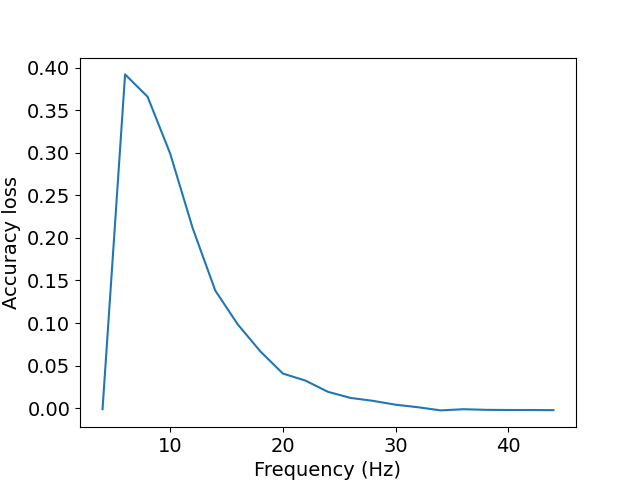

In [20]:
%matplotlib widget

hw = 2
subs = 4
paths = ldapath = [os.path.join(
    '..', 'results', 'cichy_epoched',
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'PFIfreq_hw2', 'val_loss_PFIfreqs4.npy') for i in range(subs)]

xf = fftfreq(50, 1/100)[:50//2]
xf = xf[hw:50//2-hw]
xf = np.round(xf)

pfi_full = []
for path in paths:
    pfi = np.load(open(path, 'rb'))
    pfi = pfi[0, 0] - pfi[:, 1:]

    pfi_full.append(pfi)

pfi = np.mean(np.array(pfi_full), axis=(0, 1))

sns.lineplot(x=xf, y=pfi)

# add axis labels
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accuracy loss')

# Spatial PFI

In [ ]:
closest1 = []
for i in range(102):
    closest1.append(np.array([i]))

pickle.dump(np.array(closest1), open('closest1', 'wb'))

In [ ]:
def PFIch(pfipaths, ldapaths, inverse=False):
    lda_full = []
    pfi_full = []
    for pfipath, ldapath in zip(pfipaths, ldapaths):
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # load pfi from pfipath
        pfits = np.mean(np.load(open(pfipath, 'rb')), axis=0)
        if not inverse:
            pfits = pfits[0, 0] - pfits
        pfits = pfits[:, 1:]

        # crop lda to same length as pfits
        lda_full.append(np.array(lda))
        pfi_full.append(pfits)

    lda_full = np.mean(np.array(lda_full), axis=0)
    pfi_full = np.mean(np.array(pfi_full), axis=0)

    # plot
    vmin = 0.8 if inverse else 0
    evoked = mne.EvokedArray(pfi_full.T, raw.info, tmin=0)
    evoked.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=100,
                        units='Accuracy loss',
                        time_format='',
                        vmin=vmin)

    evoked = mne.EvokedArray(lda_full.reshape(-1, 1), raw.info, tmin=0)
    evoked.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=100,
                        units='Accuracy',
                        time_format='',
                        vmin=0.8)

In [ ]:
# PFIch
%matplotlib widget
subs = 15
pfipath = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'val_loss_PFIclosest1.npy') for i in range(subs)]
pfipath_inv = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'lda25hz_noshuffle_conv80', 'subj' + str(i),
    'PFIch_inverse', 'val_loss_PFIclosest1.npy') for i in range(subs)]
ldapath = [os.path.join(
    '..', 'results', 'cichy_epoched',
    'indiv_lda_25hz_conv80', 'subj' + str(i),
    'channels', 'val_loss.txt') for i in range(subs)]
PFIch(pfipath, ldapath, inverse=False)
PFIch(pfipath_inv, ldapath, inverse=True)

# Replay sliding window

In [ ]:
def load_lda(ldapaths):
    lda_full = []
    for ldapath in ldapaths:
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # crop lda to same length as pfits
        lda_full.append(np.array(lda))

    return np.array(lda_full)

def sliding_replay(ldapaths, chance=0.125, time_end=960, df_fe=None, df_fe_pca):
    lda_full = load_lda(ldapaths[0])
    ldapca_full = load_lda(ldapaths[1])
    print(lda_full.shape)

    time_range = list(range(50, time_end, 10))

    p_values = []
    for i, t in enumerate(time_range):
        test1 = lda_full[:, i]
        test2 = df_fe['Validation accuracy'][df_fe['model']=='LDA-NN']
            
        p_values.append(stats.wilcoxon(test1, test2)[1] * len(time_range))

    print(p_values)

    

    # plot pfi_full and lda_full with sns lineplot
    sns.set_context('paper')
    sns.set_style('white')
    
    # create a dataframe for the plot
    df = pd.DataFrame()

    times = []
    subjects = []
    values = []
    values_pca = []
    model = []
    for i in range(lda_full.shape[0]):
        times.extend(time_range)
        subjects.extend([i] * lda_full.shape[1])
        values.extend(lda_full[i])
        values_pca.extend(ldapca_full[i])

    df['time'] = times
    df['subject'] = subjects
    df['LDA-NN SW'] = values
    df['LDA-PCA SW'] = values_pca

    p_values_sw = []
    for i, t in enumerate(time_range):
        test1 = df['Validation accuracy'][(df['time'] == t) & (sliding_df['model type'] == 'LDA-PCA SW')]
        test2 = df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-NN SW')]
            
        p_values_sw.append(stats.wilcoxon(test1, test2)[1] * len(time_range))

    # plot lda_full and pfi_full
    fig, ax = plt.subplots(figsize=(6, 6))
    avg = np.average(df_fe['Validation accuracy'][df_fe['model']=='LDA-NN'])
    ax.axhline(avg, ls='--', color='orange', label='LDA-NN FE')

    dots = np.array(time_range)[np.array(p_values)<0.05]
    ax.plot(dots, [0.6]*len(dots), 'ro', markersize=2, label='LDA-NN FE > LDA-NN SW (p<0.05)')

    ax.set_ylim(0.1)
    ax.axhline(chance, ls='--', color='black', label='chance level')

    sns.lineplot(data=df,
                 x='time',
                 y='LDA-NN SW',
                 color=orange,
                 ax=ax,
                 legend='full',
                 n_boot=1000,
                 label='LDA-NN SW')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Validation accuracy')

    

In [ ]:
subs = 23
ldapath = [os.path.join(
    '..', 'results', 'replay_epoched',
    'lda_conv_25hz', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(1,subs)]
sliding_replay(ldapath, df_fe=df)

# Temporal PFI

In [ ]:
def PFIts(pfipaths, ldapaths, chance, shift=1, inverse=False, time_end=450, replay=False, df_fe=None):
    lda_full = []
    pfi_full = []
    for pfipath, ldapath in zip(pfipaths, ldapaths):
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # load pfi from pfipath
        pfits = np.load(open(pfipath, 'rb'))
        if not inverse:
            pfits = pfits[0, 0] - pfits
        pfits = pfits[:, 2:]

        # crop lda to same length as pfits
        lda = np.array(lda[shift:pfits.shape[1]+shift])
        lda_full.append(lda)
        pfi_full.append(pfits)

    lda_full = np.array(lda_full)

    if replay:
        p_values = []
        for i, t in enumerate(range(60, time_end, 10)):
            test1 = lda_full[:, i]
            test2 = df_fe['Validation accuracy'][df_fe['model']=='LDA-NN']
            
            p_values.append(stats.wilcoxon(test1, test2)[1] * 79)

        print(p_values)

    lda_full = np.mean(lda_full, axis=0)
    pfi_full = np.mean(np.array(pfi_full), axis=0)

    # plot pfi_full and lda_full with sns lineplot
    sns.set_context('paper')
    sns.set_style('white')
    
    # create a dataframe for the plot
    df = pd.DataFrame()
    df['time'] = np.arange(60, time_end, 10)
    df['lda'] = lda_full

    # flatten pfi_full and add to a different df
    # add a column for permutations which is axis 0 in pfi_full
    df_pfi = pd.DataFrame()
    df_pfi['time'] = np.tile(np.arange(60, time_end, 10), pfi_full.shape[0])
    df_pfi['pfi'] = pfi_full.reshape(-1)
    df_pfi['permutation'] = np.repeat(np.arange(pfi_full.shape[0]), pfi_full.shape[1])

    # plot lda_full and pfi_full
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(data=df, x='time', y='lda', color=orange, ax=ax)
    #sns.lineplot(data=df_pfi, x='time', y='pfi', color=blue, ax=ax)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Validation accuracy', color=orange)

    # set legend
    ax.legend(['LDA-NN SW'], loc='upper left')

    # add a second y axis on the right
    ax2 = ax.twinx()
    sns.lineplot(data=df_pfi, x='time', y='pfi', color=blue, ax=ax2)
    ax2.set_ylabel('Validation accuracy loss', color=blue)
    ax2.legend(['LDA-NN FE PFI'], loc='upper right')

    if replay:
        avg = np.average(df_fe['Validation accuracy'][df_fe['model']=='LDA-NN'])
        ax.axhline(avg, ls='--', color='orange', label='LDA-NN FE')

        dots = np.array(range(60, time_end, 10))[np.array(p_values)<0.05]
        ax.plot(dots, [0.6]*len(dots), 'ro', markersize=2, label='LDA-NN FE > LDA-NN SW (p<0.05)')


    # set lower and upper limits of y axis
    ax.set_ylim(chance)
    ax2.set_ylim(0.0)
    if replay:
        ax2.set_ylim(0.0, 0.22)

    ax.axhline(chance, ls='--', color='black', label='chance level')
    

In [ ]:
%matplotlib inline
# PFIts
pfipath = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'indiv_lda_25hz_conv80', 'subj' + str(i),
    'PFIts', 'val_loss_PFIts.npy') for i in range(15)]
pfipath_inv = [os.path.join(
    '..', 'results', 'cichy_epoched', 
    'indiv_lda_25hz_conv80', 'subj' + str(i),
    'PFIts_inverse', 'val_loss_PFIts.npy') for i in range(15)]
ldapath = [os.path.join(
    '..', 'results', 'cichy_epoched',
    'indiv_lda_25hz_conv80', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(15)]
PFIts(pfipath, ldapath, chance=0.008)
PFIts(pfipath_inv, ldapath, chance=0.008, inverse=True)

In [ ]:
# PFIts
pfipath = [os.path.join(
    '..', 'results', 'cichy92_epoched', 
    'lda_25hz_conv80', 'subj' + str(i),
    'val_loss_PFIts.npy') for i in range(15)]
ldapath = [os.path.join(
    '..', 'results', 'cichy92_epoched',
    'lda_25hz_conv80', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(15)]
PFIts(pfipath, ldapath, chance=0.011, shift=11)

In [ ]:
# PFIts
subs = 23
pfipath = [os.path.join(
    '..', 'results', 'replay_epoched', 
    'lda_conv_25hz_900ms', 'subj' + str(i),
    'val_loss_PFIts.npy') for i in range(1,subs)]
ldapath = [os.path.join(
    '..', 'results', 'replay_epoched',
    'lda_conv_25hz', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(1,subs)]
PFIts(pfipath, ldapath, chance=0.125, time_end=850, replay=False, df_fe=df)

# Model comparison

In [ ]:
%matplotlib widget
df = pd.read_csv('models.txt', sep="\t", header=0)
sliding_plot = sns.lineplot(data=df,
                            x="Time (ms)",
                            y="Validation accuracy",
                            hue='Model',
                            legend='full')

# Sliding window sizes

In [ ]:
def load_df(path, df):
    # Load sliding window data
    sliding_df = pd.read_csv(path, sep="\t", header=0)
    sliding_df = sliding_df.stack().reset_index()
    sliding_df = sliding_df.rename(columns={'level_0': 'subject', 'level_1': 'Time (ms)', 0: 'Validation accuracy'})

    model_type = []
    for i in range(len(sliding_df)):
        if '10ms' in sliding_df['Time (ms)'][i]:
            model_type.append('10ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (10ms)', '')
        elif '100ms' in sliding_df['Time (ms)'][i]:
            model_type.append('100ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (100ms)', '')
        elif '200ms' in sliding_df['Time (ms)'][i]:
            model_type.append('200ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (200ms)', '')
        elif '300ms' in sliding_df['Time (ms)'][i]:
            model_type.append('300ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (300ms)', '')
        elif '400ms' in sliding_df['Time (ms)'][i]:
            model_type.append('400ms')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (400ms)', '')

    sliding_df['model type'] = model_type

    # convert Time (ms) to int
    sliding_df['Time (ms)'] = sliding_df['Time (ms)'].astype(int)

    sub_df = df[df['model'] == 'LDA-NN']

    grouped_df = sliding_df.groupby(['Time (ms)', 'model type']).mean().reset_index()

    errors = []
    conf_int = []
    for t, m in zip(grouped_df['Time (ms)'], grouped_df['model type']):
        slice = np.array(sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == m)])
        err = slice - np.array(sub_df['Validation accuracy'])
        errors.append(err)

        conf_int.append(stats.t.interval(0.95, len(err)-1, loc=np.mean(err), scale=stats.sem(err)))
        # add back the mean
        conf_int[-1] = (conf_int[-1][0] + slice.mean(), conf_int[-1][1] + slice.mean())

    return sliding_df, conf_int

In [ ]:
sub_df = df118[df118['model'] == 'LDA-NN']
err = np.array(cichy118_df['Validation accuracy'][(cichy118_df['Time (ms)'] == 145) & (cichy118_df['model type'] == '100ms')]) - np.array(sub_df['Validation accuracy'])
stats.t.interval(0.95, len(err)-1, loc=np.mean(err), scale=stats.sem(err))

In [ ]:
def plot_df(ax, sliding_df, df, conf_int, chance=0.008):
    p_200 = []
    p_300 = []
    p_400 = []

    tvals200 = list(range(95, 400, 10))
    tvals300 = list(range(145, 350, 10))
    tvals400 = list(range(195, 300, 10))

    all_comparisons = sum([len(tvals200), len(tvals300), len(tvals400)])
    for t in tvals200:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '200ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_200.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    for t in tvals300:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '300ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_300.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    for t in tvals400:
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == '400ms')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_400.append(stats.wilcoxon(test1, test2)[1] * all_comparisons)

    # lines for full-epoch accuracy
    dots = np.array(tvals200)[np.array(p_200)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.7]*len(dots), 'go', markersize=2, label='LDA-NN FE <> LDA-NN 200ms (p<0.05)')

    dots = np.array(tvals300)[np.array(p_300)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.72]*len(dots), 'ro', markersize=2, label='LDA-NN FE <> LDA-NN 300ms (p<0.05)')

    dots = np.array(tvals400)[np.array(p_400)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    ax.plot(dots, [0.74]*len(dots), 'o', color='purple', markersize=2, label='LDA-NN FE <> LDA-NN 400ms (p<0.05)')

    # modify sliding_df so that the subject column is averaged out
    sliding_df = sliding_df.groupby(['Time (ms)', 'model type']).mean().reset_index()
    sliding_df['conf_int'] = conf_int

    # Plot sliding window data, with legend inside the plot and sparse x ticks
    sliding_plot = sns.lineplot(data=sliding_df,
                                x="Time (ms)",
                                y="Validation accuracy",
                                hue='model type',
                                legend='full',
                                ax=ax)

    ax.set_xlim(0, None)

    ax.axhline(avg, ls='--', color='grey', label='full-epoch accuracy')

    ax.axhline(chance, ls='--', color='black', label='chance level')

In [ ]:
cichy118_df, conf_int = load_df('sliding_windows.txt', df118)
plt.rcParams.update({'font.size': 20})
%matplotlib inline
fig, axes = plt.subplots(figsize=(5, 6))


plot_df(axes, cichy118_df, df118, conf_int, 0.008)

handles, labels = axes.get_legend_handles_labels()

# remove legend of axes
axes.legend_.remove()
axes.legend(handles,
           labels,
           loc=(-1, -1),
           bbox_to_anchor=(1.02, 0.3),
           fancybox=True,
           shadow=True)
e=0

# Sliding window

In [ ]:
def load_df_replay(ldapaths):
    lda_full = []
    for ldapath in ldapaths:
        # load accuracies from ldapath
        lda = []
        with open(ldapath, 'r') as f:
            for line in f:
                lda.append(float(line.strip()))

        # crop lda to same length as pfits
        lda_full.append(np.array(lda)[:80])

    return  np.array(lda_full)


def merge_replay(nn, pca):
    time_range = list(range(45, 840, 10))

    times = []
    subjects = []
    values = []
    model = []
    for i in range(nn.shape[0]):
        times.extend(time_range)
        subjects.extend([i] * nn.shape[1])
        values.extend(nn[i])
        model.extend(['LDA-NN SW'] * nn.shape[1])

    for i in range(pca.shape[0]):
        times.extend(time_range)
        subjects.extend([i] * pca.shape[1])
        values.extend(pca[i])
        model.extend(['LDA-PCA SW'] * pca.shape[1])

    # create a dataframe for the plot
    df = pd.DataFrame()

    df['Time (ms)'] = times
    df['subject'] = subjects
    df['Validation accuracy'] = values
    df['model type'] = model

    return df

In [ ]:
def load_df(path):
    # Load sliding window data
    sliding_df = pd.read_csv(path, sep="\t", header=0)
    sliding_df = sliding_df.stack().reset_index()
    sliding_df = sliding_df.rename(columns={'level_0': 'subject', 'level_1': 'Time (ms)', 0: 'Validation accuracy'})

    model_type = []
    for i in range(len(sliding_df)):
        if 'pca' in sliding_df['Time (ms)'][i]:
            model_type.append('LDA-PCA SW')
            sliding_df['Time (ms)'][i] = sliding_df['Time (ms)'][i].replace(' (pca)', '')
        else:
            model_type.append('LDA-NN SW')
    sliding_df['model type'] = model_type

    # convert Time (ms) to int
    sliding_df['Time (ms)'] = sliding_df['Time (ms)'].astype(int)

    return sliding_df

In [ ]:
def plot_df(ax, sliding_df, df, chance, end=840):
    p_values = []
    p_conv = []
    p_pca = []
    leng = int(end/10)
    for t in range(45, end, 10):
        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-PCA SW')]
        test2 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-NN SW')]
        
        p_values.append(stats.wilcoxon(test1, test2)[1] * leng)

        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-NN SW')]
        test2 = df['Validation accuracy'][df['model']=='LDA-NN']
        
        p_conv.append(stats.wilcoxon(test1, test2)[1] * leng)

        test1 = sliding_df['Validation accuracy'][(sliding_df['Time (ms)'] == t) & (sliding_df['model type'] == 'LDA-PCA SW')]
        test2 = df['Validation accuracy'][df['model']=='LDA-PCA']
        
        p_pca.append(stats.wilcoxon(test1, test2)[1] * leng)

    
    dots = np.array(range(45, end, 10))[np.array(p_values)<0.05]
    ax.plot(dots, [0.5]*len(dots), 'ro', markersize=2, label='LDA-NN SW > LDA-PCA SW (p<0.05)')

    # lines for full-epoch accuracy
    dots = np.array(range(45, end, 10))[np.array(p_conv)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-NN'])
    #ax.plot(dots, [avg]*len(dots), 'bo', markersize=2, label='LDA-NN FE > LDA-NN SW (p<0.05)')
    ax.axhline(avg, ls='--', color='orange', label='LDA-NN FE')

    dots = np.array(range(45, end, 10))[np.array(p_pca)<0.05]
    avg = np.average(df['Validation accuracy'][df['model']=='LDA-PCA'])
    #ax.plot(dots, [avg]*len(dots), 'o', color='orange', markersize=2, label='LDA-PCA FE > LDA-PCA SW (p<0.05)')
    ax.axhline(avg, ls='--', color='blue', label='LDA-PCA FE')

    # Plot sliding window data, with legend inside the plot and sparse x ticks
    sliding_plot = sns.lineplot(data=sliding_df,
                                x="Time (ms)",
                                y="Validation accuracy",
                                hue='model type',
                                hue_order=['LDA-PCA SW', 'LDA-NN SW'],
                                legend='full',
                                n_boot=1000,
                                ax=ax)

    ax.set_xlim(0, None)

    if chance<0.01:
        ax.set_ylabel('')

    ax.axhline(chance, ls='--', color='black', label='chance level')

    #ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

In [ ]:
cichy118_df = load_df('cichy118_sliding.txt')
cichy92_df = load_df('cichy92_sliding.txt')

subs = 23
ldapath = [os.path.join(
    '..', 'results', 'replay_epoched',
    'lda_conv_25hz', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(1,subs)]
replay_nn = load_df_replay(ldapath)

ldapath = [os.path.join(
    '..', 'results', 'replay_epoched',
    'lda_25hz_900ms', 'subj' + str(i),
    'windows', 'val_loss.txt') for i in range(1,subs)]
replay_pca = load_df_replay(ldapath)

replay_df = merge_replay(replay_nn, replay_pca)

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(1, 3)

plot_df(axes[1], cichy118_df, df118, 0.008)
plot_df(axes[0], cichy92_df, df92, 0.011)
plot_df(axes[2], replay_df, dfreplay, 0.125)

handles, labels = axes[0].get_legend_handles_labels()

# remove legend of axes
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()
fig.legend(handles,
           labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.02),
           fancybox=True,
           shadow=True,
           ncol=3)
e=0

# Full epoch

In [ ]:
df = pd.read_csv('cichy92_epoch.txt', sep="\t", header=0)
df = df.stack().reset_index()
df92 = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

In [ ]:
%matplotlib widget

plt.rcParams.update({'font.size': 14})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  1,
    'cut':     0,
    'ci':      None,
    'scale':   'width',
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.125, ls='--', color='black', label='chance')
plt.ylim(0, 1)
plt.xlabel('')
#plt.text(2.1,0.015,'chance')

# which pairs to computer stats on
pairs = [('LDA-PCA', 'LDA-NN'), ('LDA-NN', 'Neural Network')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()
#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/mvpa_figures/cichy118_epoch.pdf', format='pdf')